In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import utils
import gpfunctions as gp
import lstm_model

In [9]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [13]:
LOSS_FUNCS = ['MIN', 'OI', 'SUMMIN']
BASELINES = ['SKOPT', 'RANDOM'] 

In [45]:
def average_min_found_values_across_rows(values):
    return np.mean(np.apply_along_axis(utils.min_up_to_k, 1, values), axis=0)

    def find_y_randomly(X_test, A_test, min_test, max_test, dim, kernel, n_test=2000, n_steps=20, n_bumps=6.0):
    params = {
        'function': gp.normalized_gp_function,
        'kernel': gp.kernel_function(kernel),
        'dim': dim,
        'l': 2/n_bumps*np.sqrt(dim),
        'n_steps': n_steps+1,
        'n_test': n_test,
        'X_test': X_test,
        'A_test': A_test,
        'min_test': min_test,
        'max_test': max_test
    }
    return lstm_model.get_random_baseline(**params)

In [4]:
def find_y_from_lstm(X_test, A_test, min_test, max_test, kernel, dim, loss, n_steps=20, debug=False):
    
    model = utils.get_trained_model(dim=dim, kernel=kernel, loss=loss)    
    starting_point = utils.loadConfig()['experiments']['%dD'%dim]['hyperparameters']['starting_point'][0]


    data_Xt = X_test
    data_At  = A_test
    data_mint = min_test.reshape(-1,1)
    data_maxt = max_test.reshape(-1,1)

    model_params = lstm_model.load_model_params(model, debug=False)

    with tf.Session() as sess:
        params_dict = {
            'n_bumps': model_params['n_bumps'],
            'dim' : model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'forget_bias': model_params['forget_bias'],
            'n_steps': model_params['n_steps'],
            'l': model_params['gp_length'],
            'scope': model_params['scope']
        }

        Xt, At, mint, maxt, samples_x, samples_y, x_0, _, _ = lstm_model.build_training_graph(**params_dict)

        saver = tf.train.Saver()
        saver.restore(sess, model_params['model_path'])

        feed_dict = {
            Xt: data_Xt,
            At: data_At,
            mint: data_mint,
            maxt: data_maxt,
            x_0: np.array(starting_point).reshape(1,-1)
        }

        res = sess.run(samples_y, feed_dict=feed_dict)

        return np.array(res).reshape(n_steps+1,-1).T

# print(model_name)
# compute_y_from_all_testing_data(utils.)
# compute_y_from_all_testing_data(model_name, dim=1, kernel='rbf', starting_point=[-1])

In [47]:
def plot_min_comparison_of_dim_and_kernel(dim, kernel):
    data = {}
    
    # load SKOPT
    skopt_y = np.load('./skopt-result/gp_minimize/%dd-%s-samples_y.npy' % (dim, kernel))
    data['SKOPT'] = average_min_found_values_across_rows(skopt_y)
    
    # load test data
    X_test, A_test, min_test, max_test = utils.loadData(dim, 'testing', kernel)
    
    # load RANDOM    
    random_y = find_y_randomly(X_test, A_test, min_test, max_test, dim, kernel)
    data['RANDOM'] = average_min_found_values_across_rows(random_y)
    
    # load LSTM data
    for loss in LOSS_FUNCS:
        y_values = find_y_from_lstm(X_test, A_test, min_test, max_test, dim=dim, kernel=kernel, loss=loss)
        data[loss] = average_min_found_values_across_rows(y_values)
        
    
    for k in BASELINES:
        plt.plot(data[k], label=k)

    for k in LOSS_FUNCS:
        plt.plot(data[k], label='LSTM-%s'%k)
    
    xticks = range(0,skopt_y.shape[1],2)
    yticks = np.arange(-1.2, 0.2, 0.2)
    plt.ylabel('Min Found')
    plt.xlabel('Evaluation Step')
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.title('%dD-%s' % (dim, kernel.upper()))
    plt.legend()

def plot_comparision_of_dim(dim):
    kernels = ['rbf', 'matern32']
    plt.figure(figsize=(15,4))
    
    for i in range(len(kernels)):
        plt.subplot(1,2,i+1)
        plot_min_comparison_of_dim_and_kernel(dim=dim, kernel=kernels[i])

In [ ]:
plot_comparision_of_dim(dim=1)

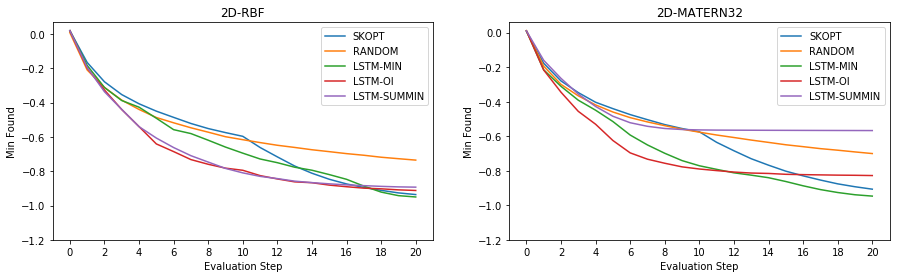

In [40]:
plot_comparision_of_dim(dim=2)

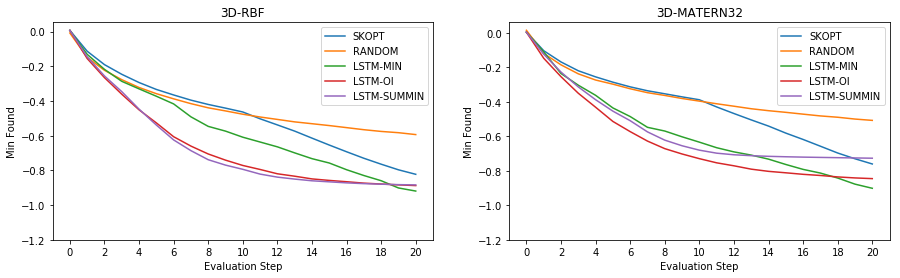

In [41]:
plot_comparision_of_dim(dim=3)

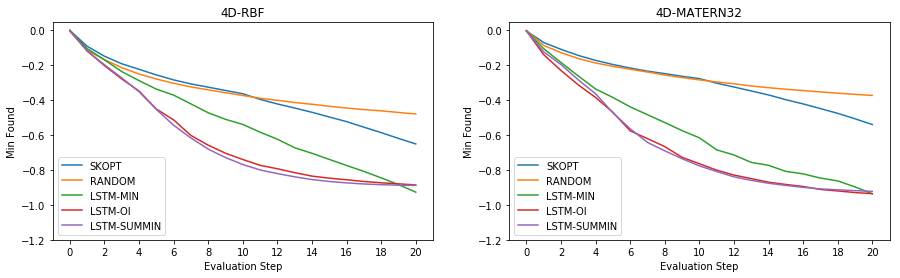

In [43]:
plot_comparision_of_dim(dim=4)

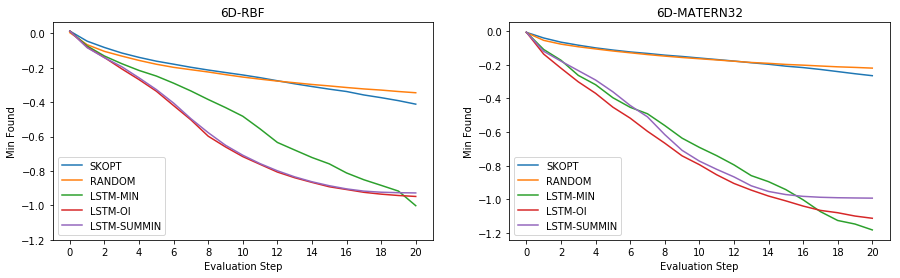

In [49]:
plot_comparision_of_dim(dim=6)